# Read in the route flows (aij matrix) or OD flows (P_mat)
### create plots of OD_flow vs time for selected OD relations
### create heatmaps of OD_flow vs. time
### calculate MSE of OD_Flow across models and/or vs. a reference. MLP 2 routes aij
### calculate MSE of calcualted counts vs. actual
### analysis of zero-flow edges vs. counters with counts: where, what systematic cause
### would an ensemble (mean, std dev/sqrt(N)) give a most likely best OD distribution?


In [1]:
import pandas as pd
import geopandas
import numpy as np
import cvxpy as cvx
import osmnx as osmnx
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
data_dir = "../UTD2019/"
counts_file = "utd19_u - Copy.csv"
detectors_file = "detectors_public - Copy.csv"
links_file = "links.csv"

In [3]:
city="melbourne"

# Output filenames are somewhat garbled.
# The first portion of the name is the name of the model.
### Aij and P_mat were calcualted for all models so the suffix "Aij" or "P_mat".npz means this matrix, regardless of the rest of the filename.
### Aij and P_mat only change if the number of routes changes so they are duplicated in the output
### _num means number of routes per OD relation

In [4]:
data=np.load(data_dir+"/OSM/"+city+"/Aij.npz")#MLP_aij_test_2_Aij
aij_2=data["aij"]
data=np.load(data_dir+"/OSM/"+city+"/AE_P_mat_test_1_Aij.npz")#
aij_1=data["aij"]
data=np.load(data_dir+"/OSM/"+city+"/Aij_5_route.npz")
aij_5=data["aij"]
data=np.load(data_dir+"/OSM/"+city+"/Aij_10_route.npz")#MLP_aij_test_10_Aij
aij_10=data["aij"]
data=np.load(data_dir+"/OSM/"+city+"/MLP_aij_test_25_Aij.npz")
aij_25=data["aij"]

### Aij matrix across different numbers of routes/OD

In [5]:

print("%5.3f,%5.3f,%5.3f,%5.3f,%5.3f" % (np.sum(aij_1)/(aij_1.size),np.sum(aij_2)/(aij_2.size),np.sum(aij_5)/(aij_5.size),np.sum(aij_10)/(aij_10.size),np.sum(aij_25)/(aij_25.size)))
print(aij_1.shape, aij_2.shape, aij_5.shape, aij_10.shape, aij_25.shape)

0.033,0.036,0.041,0.044,0.050
(67, 319) (67, 627) (67, 1545) (67, 3075) (67, 7665)


### Open the od_pairs file (list)

In [6]:
import json
import pickle

with open(data_dir+"/OSM/"+city+"/od_pairs.pkl", 'rb') as f:
    od_pairs = pickle.load(f)

with open(data_dir+"/OSM/"+city+"/od_route_names_dict_1.pkl", "rb") as f:
    od_route_names_dict_1=pickle.load(f)

with open(data_dir+"/OSM/"+city+"/od_route_names_dict_2.pkl", "rb") as f:
    od_route_names_dict_2=pickle.load(f)

with open(data_dir+"/OSM/"+city+"/od_route_names_dict_5.pkl", "rb") as f:
    od_route_names_dict_5=pickle.load(f)

with open(data_dir+"/OSM/"+city+"/od_route_names_dict_10.pkl", "rb") as f:
    od_route_names_dict_10=pickle.load(f)

with open(data_dir+"/OSM/"+city+"/od_route_names_dict_25.pkl", "rb") as f:
    od_route_names_dict_25=pickle.load(f)

In [7]:
# Make OD flows out of the route flows by summing over route flows for each OD

def od_flow_from_route_flow(od_pairs, route_flows,od_route_names_dict):
    
 # Make OD flows out of the route flows by summing over route flows for each OD
    I=route_flows.shape[1]
    J=len(od_pairs)
    j=0
    i_r=0
    od_flow=np.zeros((I))
    od_flow_matrix=np.zeros((J,I))
    for od in od_pairs:
        od_flow=0
        rs=od_route_names_dict[od]
        for r in rs:
            od_flow=od_flow+route_flows[i_r,:]
#            print(j,i_r,r,od_flow, route_flows[i_r,:])
            i_r+=1
        od_flow_matrix[j,:]=od_flow
        j+=1
    return(od_flow_matrix)

# The output (route or OD flows)

### Route flows

In [8]:
aijname_cpu=["route_flows_mcmc", "route_flows_cvxpy"]#npy
aijname_mlp=["MLP_aij_out","MLP_aij_cyclic_LR_out","MLP_aij_test_25_out","MLP_aij_cyclic_lr_1_route_out", "MLP_aij_cyclic_lr_5_route_out","MLP_aij_cyclic_lr_10_route_out",
"MLP_10_routes_cyclic_lr_out"]#npz
aijname_ae=["AE_aij_out","AE_aij_cyclic_lr_out","AE_aij_test_25_out"]#npz

### OD flows

In [9]:
pname_mlp=["MLP_P_mat_out",]#npz
pname_ae=["AE_P_mat_out","AE_P_mat_test_1_out","AE_P_mat_test_10_out"]#npz

# Load a model's output

In [19]:
i_model=0
modelname=aijname_cpu[i_model]
data=np.load(data_dir+"/OSM/"+city+"/"+modelname+".npy")


In [12]:
data.files

AttributeError: 'numpy.ndarray' object has no attribute 'files'

In [13]:
ytrain=data["ytrain"]
yval=data["yval"]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [14]:
yhats_train=data["yhats_train"]
yhats_val=data["yhats_val"]
out_train_cpu=data["out_train_cpu"]
out_val_cpu=data["out_val_cpu"]
avtrainloss=data["avtrainloss_trace"]
avvalloss=data["avvalloss_trace"]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
print(yval.shape,yhats_val.shape,ytrain.shape,yhats_train.shape)

(67, 287) (287, 67) (67, 1080) (1080, 67)


In [ ]:
out_val_cpu.shape

(287, 319)

In [15]:
data.shape

(627, 287)

Text(0.5, 1.0, 'Est. counts vs input counts AE_P_mat_test_10_out')

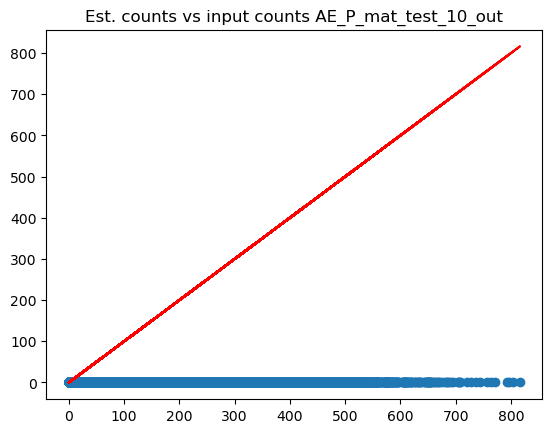

In [349]:
plt.scatter(yval,yhats_val.T)
plt.plot(yval,yval,"-",color="red")
plt.title("Est. counts vs input counts "+ modelname)

In [337]:
od_flow_matrix=od_flow_from_route_flow(od_pairs,out_val_cpu.T,od_route_names_dict_1)

In [350]:
# For P_mat
od_flow_matrix=out_val_cpu.T

In [20]:
# For MCMC and CVXPY
od_flow_matrix=od_flow_from_route_flow(od_pairs,data,od_route_names_dict_2)

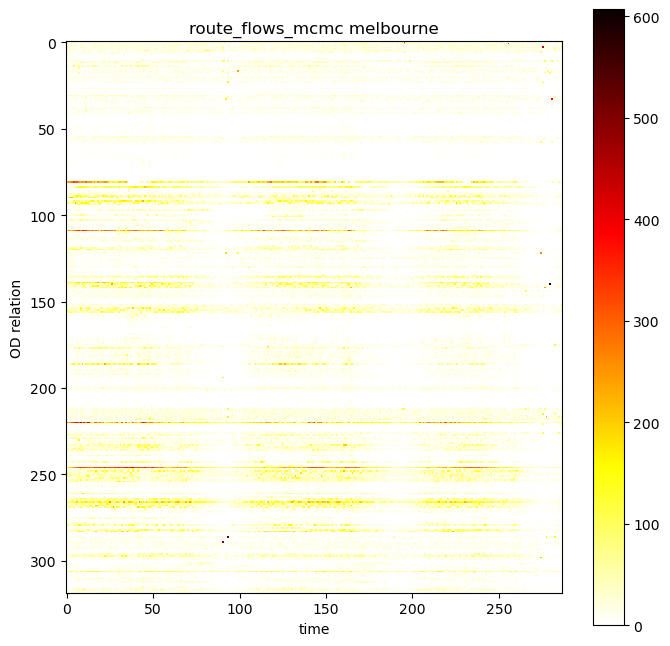

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(od_flow_matrix, cmap='hot_r', interpolation='nearest',vmin=0, vmax=np.max(od_flow_matrix))

ax.title.set_text('Validation Sample')
ax.set_ylabel("OD relation")
ax.set_xlabel("time")

plt.title(modelname + " "+ city)
#plt.title("MCMC_melbourne OD flows")
plt.colorbar(im)
plt.savefig(data_dir+"/OSM/"+city+"/"+modelname+"ODFlow_val_heat.png")
#plt.savefig(data_dir+"/OSM/"+city+"/MCMC_ODFlow_val_heat.png")
plt.show()
plt.close()

In [151]:
od_flow_matrix.shape

(319, 287)

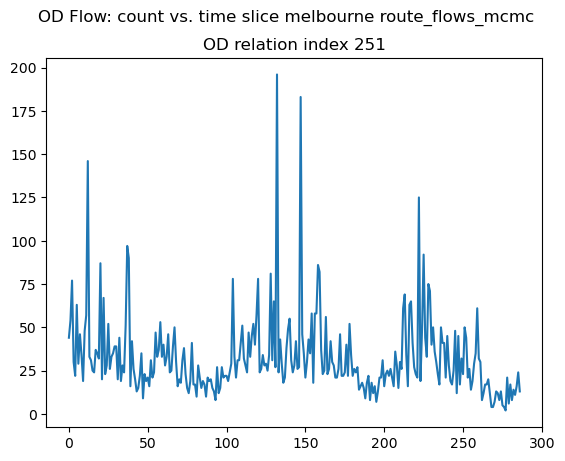

In [22]:
indx=251
plt.plot(od_flow_matrix[indx,:])
plt.suptitle("OD Flow: count vs. time slice "+city+ " "+ modelname)
plt.title("OD relation index "+str(indx))
plt.savefig(data_dir+"/OSM/"+city+"/"+modelname+"_ODFLow_val_vs_T.png")
plt.show()
plt.close()

In [303]:
od_flow_matrix_val=od_flow_from_route_flow(od_pairs,out_val_cpu.T,od_route_names_dict_2)
od_flow_matrix_train=od_flow_from_route_flow(od_pairs,out_train_cpu.T,od_route_names_dict_2)

In [169]:
# For MCMC and CVXPY which have no training set
od_flow_matrix_val=od_flow_from_route_flow(od_pairs,data,od_route_names_dict_2)

In [353]:
# For P_mat which have dim (OD)
od_flow_matrix_val=out_val_cpu.T
od_flow_matrix_train=out_train_cpu.T

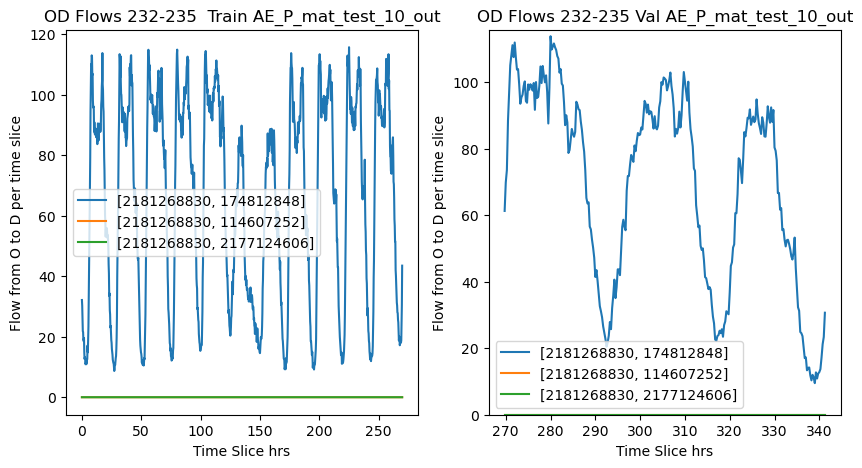

In [354]:
xx_tr=np.array(range(0,od_flow_matrix_train.shape[1]))/4.
#xx_tr=counts_time[0:i_tr]
xx_val=np.array(range(0,od_flow_matrix_val.shape[1]))/4.+np.max(xx_tr)
#xx_val=counts_time[i_tr+1:i_va]
ymax=0
fig,ax=plt.subplots(1,2,figsize=(10,5))
for ii in range(232,235):#range(counts.shape[0]):
    y=od_flow_matrix_train[ii,:]
    y[np.where(np.isnan(y))]=0
    if(ymax < np.max(y)):
        ymax=np.max(y)
    ax[0].plot(xx_tr,od_flow_matrix_train[ii,:], label=str(list(od_pairs[ii])))
plt.ylim(0,ymax)
ax[0].set_xlabel("Time Slice hrs")
ax[0].set_ylabel("Flow from O to D per time slice")
ax[0].legend()
ax[0].title.set_text("OD Flows 232-235  Train "+ modelname)

for ii in range(232,235):#range(counts.shape[0]):
    y=od_flow_matrix_val[ii,:]
    y[np.where(np.isnan(y))]=0
    if(ymax < np.max(y)):
        ymax=np.max(y)
    ax[1].plot(xx_val,od_flow_matrix_val[ii,:], label=str(list(od_pairs[ii])))
plt.ylim(0,ymax)
plt.xlabel("Time Slice hrs")
plt.ylabel("Flow from O to D per time slice")
plt.legend()
plt.title("OD Flows 232-235 Val " + modelname)
plt.savefig(data_dir+"/OSM/"+city+"/"+modelname+"_ODflows.png")
plt.show()
plt.close()

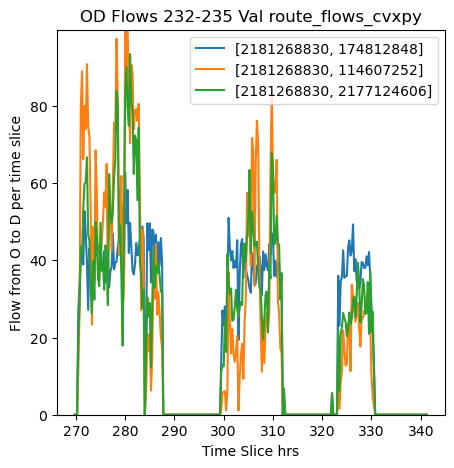

In [171]:
# For MCMC and CVXPY

xx_tr=np.array(range(0,od_flow_matrix_train.shape[1]))/4.
#xx_tr=counts_time[0:i_tr]
xx_val=np.array(range(0,od_flow_matrix_val.shape[1]))/4.+np.max(xx_tr)
#xx_val=counts_time[i_tr+1:i_va]
ymax=0
fig,ax=plt.subplots(figsize=(5,5))


for ii in range(232,235):#range(counts.shape[0]):
    y=od_flow_matrix_val[ii,:]
    y[np.where(np.isnan(y))]=0
    if(ymax < np.max(y)):
        ymax=np.max(y)
    ax.plot(xx_val,od_flow_matrix_val[ii,:], label=str(list(od_pairs[ii])))
plt.ylim(0,ymax)
plt.xlabel("Time Slice hrs")
plt.ylabel("Flow from O to D per time slice")
plt.legend()
plt.title("OD Flows 232-235 Val " + modelname)
plt.savefig(data_dir+"/OSM/"+city+"/CVXPY_ODflows.png")
plt.show()
plt.close()

In [ ]:
#RMSE
np.linalg.norm(y1 - y2) / np.sqrt(len(y1))